# Visualize drought impacts in hive plots

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate

In [88]:
# Load in all drought impacts for all realizations
drought_impacts_df = pd.read_csv('drought_impacts_all_realizations.csv', index_col=0)
drought_impacts_df.index = np.arange(1, len(drought_impacts_df) + 1)

,Duration,Magnitude,%_users,Classification
1,0,0.0,0.0,History
2,2,8.0,82.0,History
3,2,8.0,85.0,Encompassing
4,2,9.0,81.0,History
5,2,8.0,72.0,History
...,...,...,...,...
996,0,0.0,0.0,History
997,0,0.0,0.0,History
998,1,8.0,74.0,History
999,0,0.0,0.0,History


Classify outcomes into groups

In [226]:
no_users_thresh = 50
magnitude_thresh = 10
duration_thresh = 1

# create a list of our conditions
conditions = [
    # Criteria for group 1
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh) &
    (drought_impacts_df['Duration'] >= duration_thresh), 
    # Criteria for group 2
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh) &
    (drought_impacts_df['Duration'] < duration_thresh), 
    # Criteria for group 3
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh) &
    (drought_impacts_df['Duration'] >= duration_thresh),     
    # Criteria for group 4
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh) &
    (drought_impacts_df['Duration'] < duration_thresh),  
    # Criteria for group 5
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh) &
    (drought_impacts_df['Duration'] >= duration_thresh), 
    # Criteria for group 6
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh) &
    (drought_impacts_df['Duration'] < duration_thresh), 
    # Criteria for group 7
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh) &
    (drought_impacts_df['Duration'] >= duration_thresh),     
    # Criteria for group 8
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh) &
    (drought_impacts_df['Duration'] < duration_thresh),
    ] 

# create a list of the values we want to assign for each condition
group_values = list(np.arange(1,9))

# create a new column and use np.select to assign values to it using our lists as arguments
drought_impacts_df['Group'] = np.select(conditions, group_values)

In [227]:
drought_impacts_df

,Duration,Magnitude,%_users,Classification,Group
1,0,0.0,0.0,History,8
2,2,8.0,82.0,History,3
3,2,8.0,85.0,Encompassing,3
4,2,9.0,81.0,History,3
5,2,8.0,72.0,History,3
...,...,...,...,...,...
996,0,0.0,0.0,History,8
997,0,0.0,0.0,History,8
998,1,8.0,74.0,History,3
999,0,0.0,0.0,History,8


In [228]:
classifications = ['History', 'Paleo', 'Encompassing']
group_ratios = np.zeros((3,8))

In [229]:
# Loop through all classifications and all groups and calculate ratios
for i, c in enumerate(classifications):
    total_reals = len(drought_impacts_df[drought_impacts_df['Classification']==c])
    for j, value in enumerate(group_values):
        group_ratios[i,j] = np.around(len(drought_impacts_df[(drought_impacts_df['Classification']==c) & 
                                                        (drought_impacts_df['Group']==value)])/total_reals*100, 
                                 decimals=1)

In [230]:
# Create hive plot dataframe
# Calculate ratios of each group in each realization classification
df = pd.DataFrame(group_ratios, columns = [f'Group {x}' for x in group_values])
df['angle'] = [0, 120, 240]
df.loc[len(df.index)] = df.loc[0]
df.at[3, 'angle'] = 360
df

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,angle
0,18.4,0.0,13.2,0.0,0.0,0.0,0.0,68.4,0.0
1,65.0,0.0,31.9,0.0,0.0,0.0,0.0,3.1,120.0
2,86.1,0.0,13.7,0.0,0.0,0.0,0.0,0.2,240.0
3,18.4,0.0,13.2,0.0,0.0,0.0,0.0,68.4,360.0


In [231]:
cum_sum_df = df.cumsum(axis=1)
cum_sum_df.insert(0, 'Initial_values', np.zeros(4))
cum_sum_df

,Initial_values,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,angle
0,0.0,18.4,18.4,31.6,31.6,31.6,31.6,31.6,100.0,100.0
1,0.0,65.0,65.0,96.9,96.9,96.9,96.9,96.9,100.0,220.0
2,0.0,86.1,86.1,99.8,99.8,99.8,99.8,99.8,100.0,340.0
3,0.0,18.4,18.4,31.6,31.6,31.6,31.6,31.6,100.0,460.0


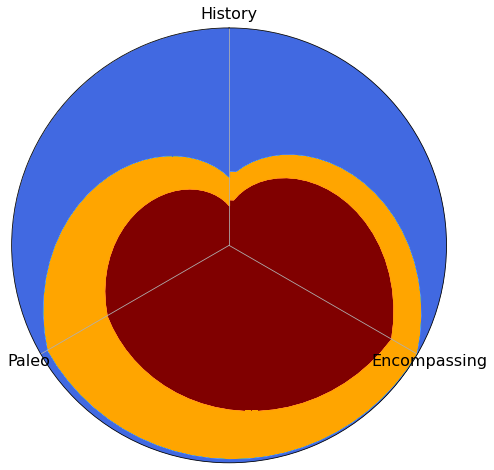

In [232]:
colors = ['maroon', 'tomato', 'orange', 'gold',
         'yellowgreen', 'forestgreen', 'lightskyblue', 'royalblue']

# Initialise the spider plot
plt.figure(figsize=(12,8))
ax = plt.subplot(polar=True)

# Extrapolate curves between angles
angles = [y/180*np.pi for x in [np.arange(x, x+120,5) for x in df.angle[:-1]] for y in x]
angles.append(360/180*np.pi)

# for every group extrapolate values and draw
for k in range(1, cum_sum_df.shape[1]-1):
    previous_values = [y for x in [np.linspace(x, cum_sum_df.iloc[:, k-1][i+1], 25)[:-1] for i, x in enumerate(cum_sum_df.iloc[:, k-1][:-1])] for y in x]
    previous_values.append(previous_values[-1])
    values = [y for x in [np.linspace(x, cum_sum_df.iloc[:, k][i+1], 25)[:-1] for i, x in enumerate(cum_sum_df.iloc[:, k][:-1])] for y in x]
    values.append(values[-1])
    
    # Plot data
    ax.fill_between(angles, previous_values, values, color=colors[k-1])

ax.set_thetagrids([0, 120, 240], classifications, fontsize=16)
ax.set_ylim([0,100])
ax.set_yticklabels([])
ax.set_rticks([])

# ax.legend()

# Fill area
#ax.fill(angles, values, 'g')

ax.set_theta_zero_location("N")


plt.show()

In [221]:
angles

[0.0,
 0.08726646259971647,
 0.17453292519943295,
 0.2617993877991494,
 0.3490658503988659,
 0.4363323129985824,
 0.5235987755982988,
 0.6108652381980153,
 0.6981317007977318,
 0.7853981633974483,
 0.8726646259971648,
 0.9599310885968813,
 1.0471975511965976,
 1.1344640137963142,
 1.2217304763960306,
 1.3089969389957472,
 1.3962634015954636,
 1.48352986419518,
 1.5707963267948966,
 1.6580627893946132,
 1.7453292519943295,
 1.8325957145940461,
 1.9198621771937625,
 2.007128639793479,
 2.0943951023931953,
 2.1816615649929116,
 2.2689280275926285,
 2.356194490192345,
 2.443460952792061,
 2.530727415391778,
 2.6179938779914944,
 2.705260340591211,
 2.792526803190927,
 2.8797932657906435,
 2.96705972839036,
 3.0543261909900767,
 3.141592653589793,
 3.2288591161895095,
 3.3161255787892263,
 3.4033920413889422,
 3.490658503988659,
 3.5779249665883754,
 3.6651914291880923,
 3.752457891787808,
 3.839724354387525,
 3.9269908169872414,
 4.014257279586958,
 4.101523742186674,
 4.1887902047863905,
